In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/tools/");

# Use Plots:
using Plots
#using PhotoStructs
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using CanopyRTMod
using BenchmarkTools
using Statistics

In [3]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;


In [4]:
#@time CanopyRTMod.optis.nr[3:20] .= 2

In [5]:
leaf = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}();


In [6]:
contourf(wle, wlf, Mb)

UndefVarError: UndefVarError: Mb not defined

In [7]:
using Parameters
@unpack N, Cab, Car, Ant, Cs, Cw, Cm, ρ_SW, τ_SW = CanopyRTMod.leaf;

In [8]:
@btime CanopyRTMod.fluspect!(CanopyRTMod.leaf, CanopyRTMod.optis);

  611.043 μs (2992 allocations: 995.05 KiB)


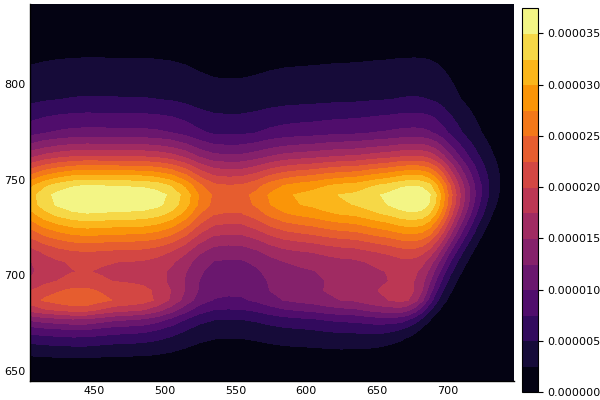

In [9]:
contourf(wle, wlf, CanopyRTMod.leaf.Mb)

In [10]:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end

In [11]:
CanopyRTMod.angles.tto=-88
CanopyRTMod.angles.psi=50
@btime CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
@btime CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
@btime CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
CanOpt2 = deepcopy(canOpt)
@btime CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);

  83.955 μs (1301 allocations: 57.22 KiB)
  12.293 μs (0 allocations: 0 bytes)
  90.371 μs (483 allocations: 304.05 KiB)
  805.824 μs (3201 allocations: 1.94 MiB)


In [12]:
# Just a test
@btime CanopyRTMod.compCanopyOptsExact!(arrayOfLeaves,canOpt, canopy.lidf);

  965.838 ms (48394460 allocations: 739.01 MiB)


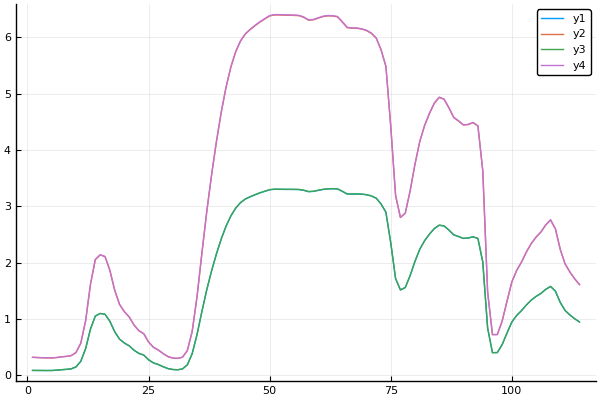

In [13]:
plot(CanOpt2.w[:,10])
plot!(CanOpt2.vb[:,1])
plot!(canOpt.w[:,1]/36)
plot!(canOpt.vb[:,1]/36)

In [14]:
CanopyRTMod.soil.albedo_SW[:] .=0.2;

In [15]:
reflVIS = []
reflNIR = []
SIF_FR = []
SIF_R  = []
Pso = []
Po = []
Ps = []
ko = []
CanopyRTMod.angles.tts=60
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI = 3
for VZA=-89.5:0.5:89.5
    CanopyRTMod.angles.tto=VZA
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
    push!(reflVIS, canRad.alb_obs[28])
    push!(reflNIR, canRad.alb_obs[52])
    push!(SIF_R , canRad.SIF_obs[8])
    push!(SIF_FR, canRad.SIF_obs[20])
    push!(Pso, canOpt.Pso[1])
    push!(Ps, canOpt.Ps[1])
    push!(Po, canOpt.Po[1])
    push!(ko, canOpt.ko[1])
end

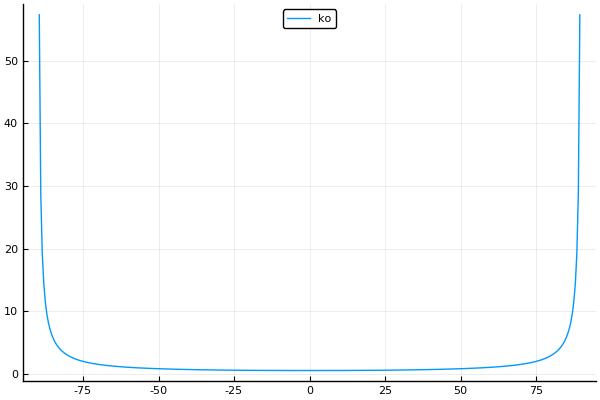

In [16]:
VZA=-89.5:0.5:89.5
plot(VZA, ko, label="ko")

wl[28] = 662.0f0
wl[52] = 817.0f0


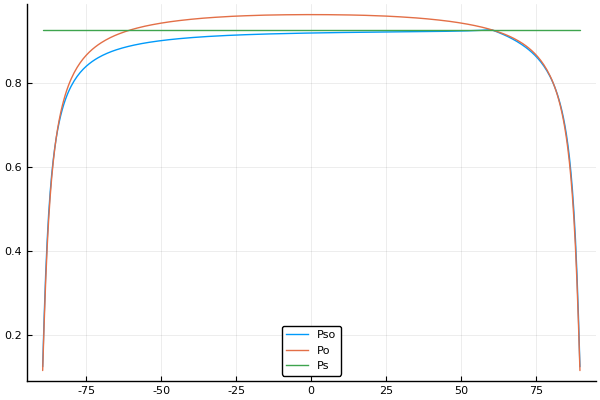

In [17]:
@show wl[28]
@show wl[52]
CanopyRTMod.angles.tts = 48

plot(VZA, Pso, label="Pso")
plot!(VZA, Po, label="Po")
plot!(VZA, Ps, label="Ps")
#@show wlf

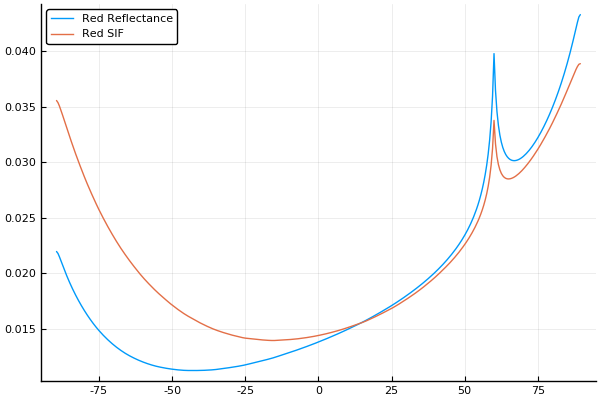

In [18]:

plot(VZA, reflVIS, label="Red Reflectance")
plot!(VZA, SIF_FR/100, label="Red SIF")

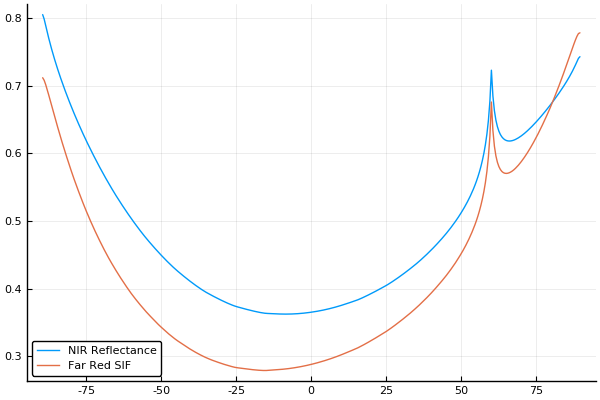

In [19]:
plot(VZA, reflNIR, label="NIR Reflectance")
plot!(VZA, SIF_FR/5, label="Far Red SIF")

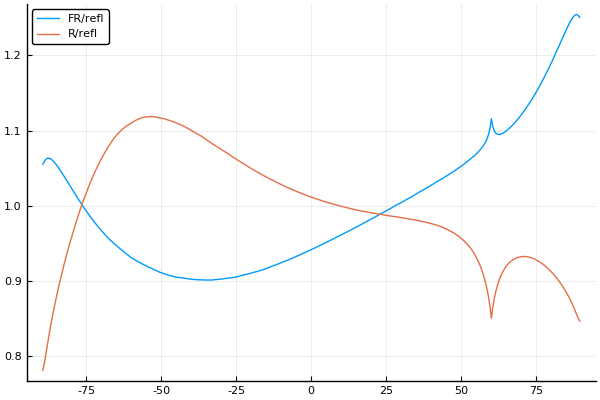

In [20]:
plot(VZA, SIF_FR./reflNIR./mean(SIF_FR./reflNIR), label="FR/refl")
plot!(VZA, SIF_R./reflVIS./mean(SIF_R./reflVIS), label="R/refl")
#plot!(VZA, , label="Far Red SIF")

In [21]:
CanopyRTMod.soil.albedo_SW[:] .=0.2;
reflRed_SZA = []
reflNIR_SZA = []
CanopyRTMod.canopy.Ω = 1.0
CanopyRTMod.angles.tto=0.2
CanopyRTMod.canopy.LAI=2.
for SZA=0.0:1:75
    CanopyRTMod.angles.tts=SZA
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(reflNIR_SZA, canRad.alb_direct[52])
end

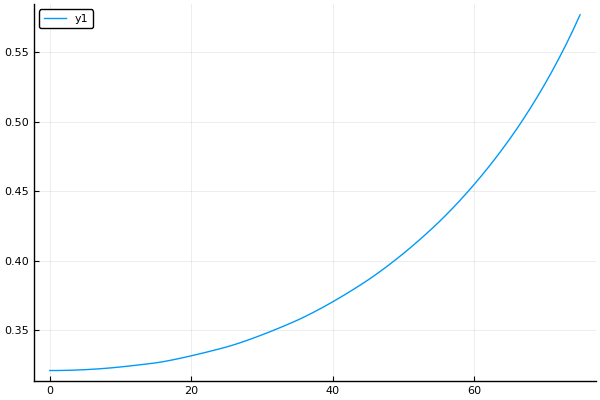

In [22]:
SZA=0:1:75
plot(SZA, reflNIR_SZA)

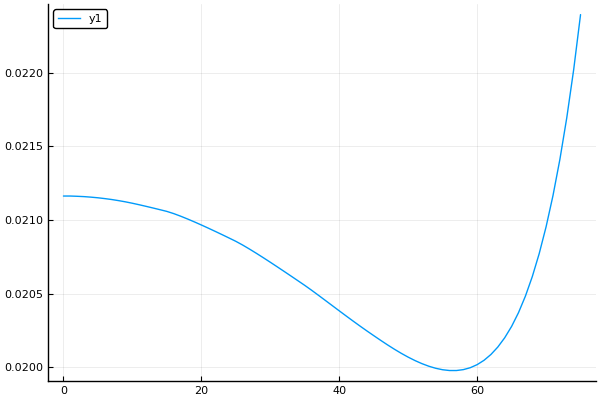

In [23]:
SZA=0:1:75
plot(SZA, reflRed_SZA)

In [24]:
# Test plots from Christiaan's papers

In [25]:
reflVIS = Float32[]
reflNIR = Float32[]
SIF_FR = Float32[]
SIF_R  = Float32[]
CanopyRTMod.angles.tts=48
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI=3.22
for psi=0:360
    CanopyRTMod.angles.psi=psi
    for VZA=0:1:85
        CanopyRTMod.angles.tto=VZA

        CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
        CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
        CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
        CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
        push!(reflVIS, canRad.alb_obs[28])
        push!(reflNIR, canRad.alb_obs[52])
        push!(SIF_R , canRad.SIF_obs[8])
        push!(SIF_FR, canRad.SIF_obs[20])
    end
end

In [26]:
A = reshape(reflNIR, ( 86,361));
B = reshape(reflVIS, ( 86,361));
SIFFER = reshape(SIF_R, ( 86,361));
SIFFER_FR = reshape(SIF_FR, ( 86,361));

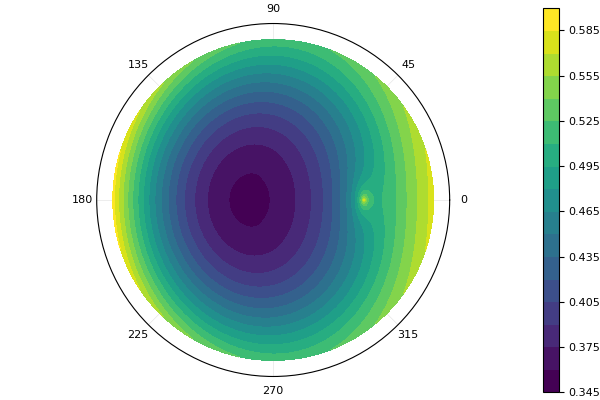

In [27]:
using Plots; pyplot()

#heatmap(A, cmap=)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  A,  proj=:polar, color=:viridis, alpha=0.5)

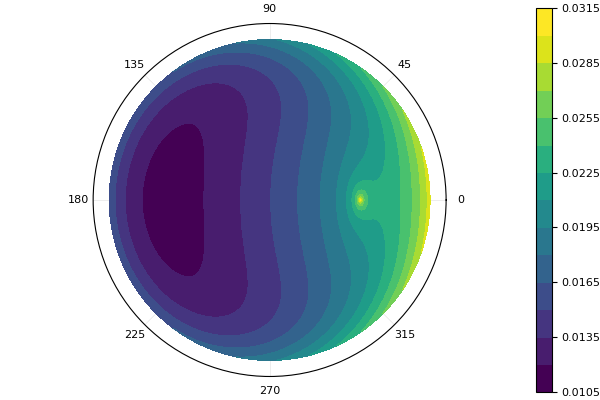

In [28]:
#heatmap(A, cmap=)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  B,  proj=:polar, color=:viridis)

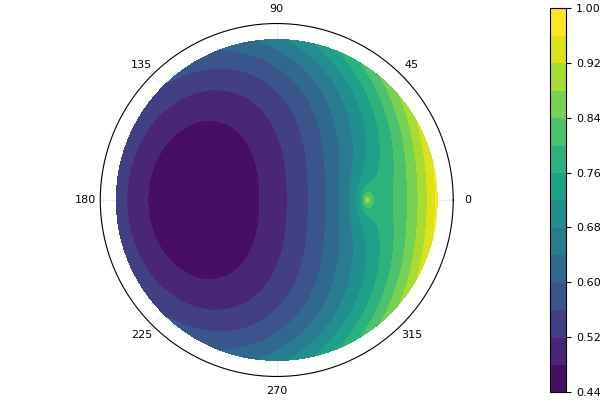

In [29]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER, proj=:polar, color=:viridis)

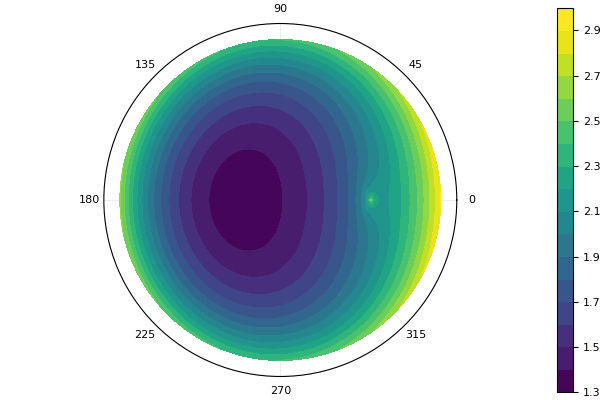

In [30]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER_FR, proj=:polar, color=:viridis)

In [31]:
# Just some testing stuff for debugging!
using LinearAlgebra
using StaticArrays
θ_l = 30.0;
θ_s = 30.0;
φ_l = 0.0;
θ_o = 40.0;
φ_o = 180.0;

In [32]:
l =  [cosd(θ_l); sind(θ_l)*cosd(φ_l);sind(θ_l)*sind(φ_l)];
n =  [1.0; 0.0; 0.0]
s =  [cosd(θ_s); sind(θ_s); 0]
o =  [cosd(θ_o); sind(θ_o)*cosd(φ_o);sind(θ_o)*sind(φ_o)];

In [33]:
@show cosd(θ_l)*(1 + tand(θ_s)*tand(θ_l)*cosd(φ_l))
@show (s⋅l)/(s⋅n)
@show (o⋅l)/(o⋅n)
@show (cosd(θ_s)*cosd(θ_l) + sind(θ_s)*sind(θ_l)*cosd(φ_l))/cosd(θ_s)

cosd(θ_l) * (1 + tand(θ_s) * tand(θ_l) * cosd(φ_l)) = 1.1547005383792517
(s ⋅ l) / (s ⋅ n) = 1.1547005383792515
(o ⋅ l) / (o ⋅ n) = 0.44647558819579863
(cosd(θ_s) * cosd(θ_l) + sind(θ_s) * sind(θ_l) * cosd(φ_l)) / cosd(θ_s) = 1.1547005383792515


1.1547005383792515

In [34]:
@show mean(canOpt.fs'*canopy.lidf)
@show canOpt.ks
@show mean(abs.(canOpt.fo)'*canopy.lidf)
@show canOpt.ko

mean((canOpt.fs)' * canopy.lidf) = 0.49109548f0
canOpt.ks = 0.7464444f0
mean((abs.(canOpt.fo))' * canopy.lidf) = 5.7571454f0
canOpt.ko = 5.755474f0


5.755474f0

In [35]:
angles

CanopyRTMod.struct_angles{Float32}(48.0f0, 85.0f0, 360.0f0)

In [36]:
mean(canOpt.absfs'*canopy.lidf)


0.746102f0